# projet 1

In [1]:
import pyvista as pv
import dolfinx
from dolfinx import mesh, fem, plot, io, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import ufl
import numpy as np
import gmsh
import meshio
from dolfinx.io import XDMFFile

import dolfinx.fem as fem
import dolfinx.mesh as mesh
from petsc4py import PETSc

In [2]:
# Initialisation de GMSH
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 0)
gmsh.model.add("cylindre")

lc = 0.1    # Longueur caractéristique des éléments en mètres

# Créer un cylindre
#gmsh.model.occ.addCylinder(0, 0, 0, 0, 0, height, radius)

#gmsh.model.occ.addCylinder(0, 0, 0, 0, 0, height, radius)
# Exemple avec les dimensions spécifiques
a = 0  # Coordonnée x du coin inférieur gauche
b = 0  # Coordonnée y du coin inférieur gauche
L = 1 # Longueur dans la direction z
width = 0.2  # Largeur dans la direction x
height = 0.2  # Hauteur dans la direction y

gmsh.model.occ.addBox(a, b, 0, width, height, L)

# Synchronisation de la géométrie
gmsh.model.occ.synchronize()

# Définir les tailles des éléments
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", lc)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", lc)

# Générer le maillage
gmsh.model.mesh.generate(3)  # 3 pour le maillage en 3D

# Sauvegarder le maillage dans un fichier .msh
gmsh.write("cylindre.msh")

# Finaliser GMSH
gmsh.finalize()

In [3]:
# Lire le fichier .msh avec meshio
msh = meshio.read("cylindre.msh")

# Sauvegarder le maillage en format XDMF
meshio.write("cylindre.xdmf", meshio.Mesh(points=msh.points, cells={"tetra": msh.cells_dict.get("tetra", [])}))

# Lire le fichier .xdmf avec Dolfinx
with XDMFFile(MPI.COMM_WORLD, "cylindre.xdmf", "r") as xdmf_file:
    domain = xdmf_file.read_mesh(name="Grid")
    domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

# Afficher des informations sur le maillage
#print("Maillage créé avec succès.")
#print(f"Nombre de sommets : {domain.topology.index_map(domain.topology.dim).size_global}")
#print(f"Nombre d'éléments : {domain.topology.index_map(domain.topology.dim-1).size_global}")

In [4]:
import panel as pn
pn.extension('vtk')

In [11]:
# Création du maillage pour PyVista basé sur les coordonnées des dofs
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(domain)

# Créez la grille PyVista et ajoutez les valeurs des dofs à la grille
u_grid = pv.UnstructuredGrid(u_topology, u_cell_types, u_geometry)

# Visualisation
p = pv.Plotter()

#u_grid.point_data["u"] = uh.x.array.reshape((u_geometry.shape[0], 2))
#warped = u_grid.warp_by_scalar("u", factor=10)
p.add_mesh(u_grid, show_edges=True, scalar_bar_args={
    "title": "u",
    "title_font_size": 24,
    "label_font_size": 22,
    "shadow": True,
    "italic": True,
    "font_family": "arial",
    "vertical": False
})
p.add_text("Poutre", font_size=12, color="black", position="upper_edge")
p.show_bounds(color="black")
p.add_axes(color="black")
p.set_background("grey")
p.show()
p.view_yz()

Widget(value='<iframe src="http://localhost:60499/index.html?ui=P_0x292fed430_1&reconnect=auto" class="pyvista…

In [6]:
ip1 = pn.pane.VTK(p.ren_win, width=750, height=500)
# Afficher dans Jupyter Book
ip1

VTKRenderWindowSynchronized(vtkCocoaRenderWindow, height=500, sizing_mode='fixed', width=750)

In [7]:
from myst_nb import glue
my_variable = "here is some text!"
glue("cool_text", my_variable)

'here is some text!'

test de la fonction {glue:}`cool_text`

{glue:}`cool_text`

In [12]:
glue("cool_text", my_variable, display=False)

retest de la fonction {glue:}`cool_text`

In [18]:
# Simulate some data and bootstrap the mean of the data
import numpy as np
np.set_printoptions(legacy="1.25")

import pandas as pd
import matplotlib.pyplot as plt

n_points = 10000
n_boots = 1000
mean, sd = (3, .2)
data = sd*np.random.randn(n_points) + mean
bootstrap_indices = np.random.randint(0, n_points, n_points*n_boots).reshape((n_boots, n_points))

In [19]:
# Calculate the mean of a bunch of random samples
means = data[bootstrap_indices].mean(0)
# Calculate the 95% confidence interval for the mean
clo, chi = np.percentile(means, [2.5, 97.5])

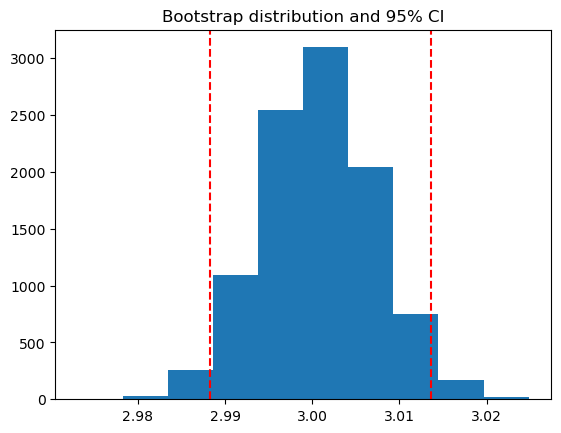

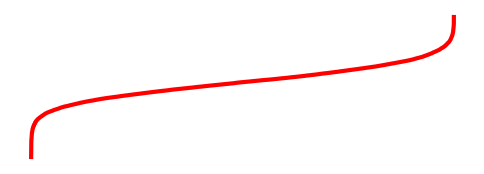

In [20]:
import matplotlib.pyplot as plt
import numpy
# Visualize the histogram with the intervals
fig, ax = plt.subplots()
ax.hist(means)
for ln in [clo, chi]:
    ax.axvline(ln, ls='--', c='r')
ax.set_title("Bootstrap distribution and 95% CI")

# And a wider figure to show a timeseries
fig2, ax = plt.subplots(figsize=(6, 2))
ax.plot(np.sort(means), lw=3, c='r')
ax.set_axis_off()


In [21]:
glue("boot_fig", fig, display=False)
glue("sorted_means_fig", fig2, display=False)

The glue tool from MyST-NB allows you to add a key to variables in a notebook, then display those variables in your book by referencing the key.

It follows a two-step process:

We’ll cover each step in more detail below.

For more information about roles, see MyST Markdown overview.
Gluing variables in your notebook
You can use myst_nb.glue() to assign the value of a variable to a key of your choice. glue will store all of the information that is normally used to display that variable (i.e., whatever happens when you display the variable by putting it at the end of a code cell). Choose a key that you will remember, as you will use it later.
{glue:}`boot_fig`
